In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import youtokentome as yttm


from tqdm import tqdm
from collections import Counter

from transformer import *
from utils import *

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
device = '/device:GPU:0'

# Set up data pipeline:

In [4]:
test_seed=1
np.random.seed(test_seed)
albums_data = pd.read_csv('albums_data.csv', sep=';', encoding='utf-8', index_col=[0]).sample(frac=1)
print(albums_data.shape)

(330802, 6)


In [5]:
albums_data.head()

,album_link,album_name,album_creators,similar_artists,directory,genre
151944,https://music.yandex.ru/album/4180600,Bowed And Popped,"Michael Vorfeld, Hans Tammen, Stefan Froleyks",NaN,albums_data/mirovaja klassika/album_4180600.jpg,classical
316917,https://music.yandex.ru/album/9379942,Midnight Listening Session,Bill Haley & His Comets,Elvis Presley|Chuck Berry|Jerry Lee Lewis,albums_data/inostrannyj rok/album_9379942.jpg,rock
138859,https://music.yandex.ru/album/38360,Super Hits,Glen Campbell,Frank Sinatra|The Beach Boys|Dolly Parton,albums_data/kantri/album_38360.jpg,country
4896,https://music.yandex.ru/album/10206571,Dispatch Dubplate 016,"Survival, Script",Utah Jazz|RIYA|Gysnoize,albums_data/dram-n-bejs/album_10206571.jpg,d&b
56784,https://music.yandex.ru/album/1811640,Able,Thomas David,NaN,albums_data/pop83/album_1811640.jpg,pop


# Pre-Processing album names

In [6]:
albums_data.reset_index(drop=True, inplace=True)
# Saving some part for testing
print(f'Previous shape: {albums_data.shape}')

np.random.seed(test_seed)
random_sample = np.random.choice(albums_data.shape[0], 3000, replace=False)
train_albums_data = albums_data.loc[~albums_data.index.isin(random_sample), :]
test_albums_data = albums_data.loc[albums_data.index.isin(random_sample), :]

print(f'Train shape: {train_albums_data.shape}, Test shape: {test_albums_data.shape}')
train_albums_data.reset_index(drop=True, inplace=True)
test_albums_data.reset_index(drop=True, inplace=True)

Previous shape: (330802, 6)
Train shape: (327802, 6), Test shape: (3000, 6)


In [7]:
# Preparing training data for tokenizer:
# Here we concatenate artist and album names with <SEP> token as separator
albums_quotes = list(map(concat_artist_album,
                         zip(train_albums_data.album_creators.tolist(),
                             train_albums_data.album_name.tolist())))

In [8]:
# Preparing training data for tokenizer:
train_data_path = "train_data.txt"
with open(train_data_path, "w", encoding='utf-8') as fout:
    for line in albums_quotes:
        print(line, end='\n', file=fout)

# Train BPE tokenizer:

For converting text to tokens BPE tokenizer was used. Among the advantages of such tokenization technique are:

1) Speed (much faster than lemmatization for example)

2) Possibility to model and account for morphology

3) No need for OOV token

In [9]:
# Training tokenizer:
VOCAB_SHAPE = 5000
model_path = "album_tokenizer.model"
# yttm.BPE.train(data=train_data_path, vocab_size=VOCAB_SHAPE, model=model_path)

In [10]:
# Loading the model
yamus_bpe = yttm.BPE(model=model_path)

In [11]:
# Looking at the vocabulary:
print(len(yamus_bpe.vocab()))
print(*yamus_bpe.vocab()[-300:])

5000
▁Scher ▁Jess ▁Ang ▁Bailey ▁Voices ▁Brazilian ▁Grapp ossom ▁Blossom ▁Concerts ▁Lux örg ▁Flo ▁Fletcher ▁Generation enk ▁Stefan ▁Second -20 ▁Camb ▁Pra ▁Vintage her ▁Ara oso ansons ote ▁Cannonball ков ▁Quincy ▁Vibes ▁Prad ▁No.1 ▁Amor ▁Jor ▁Ар beck min ▁Cosmic atoire ру ▁Lights back ▁Edu din phis ▁Etta ▁Masterpie ▁Johannes ▁Legends ▁01 ▁Theme ▁Cleveland iva ▁Ljubljana ▁Bach, ▁Gone rell ▁LP ize ▁Riddim ▁Sunday ▁See ▁Project, ▁Split ▁Mos ▁Ris ▁Milano, ▁Let's ▁Inner eur ▁Suns ▁Chakra ▁Theatre ▁Kuent vo ▁Dy ▁Zub po ía ender ▁Gibb ▁Bul ▁Gün time come ▁Amade ▁Clara ▁SP ▁Jörg ision ▁Teresa ▁Anthems ▁Xavier ▁Secret ▁Felix ▁Suites ridge, ▁Angeles ▁Tai ▁East ят et: ▁Twil vatoire ow, ▁Cav ▁Mangesh otion ▁Jean-P ▁Mills ▁A. mit ▁Meh ration ibelius ▁Yehudi ▁Puccini: ov: ▁Rar ▁Coff ▁Tribe ▁(B ▁Gav имфон ствен iko ▁Butterfly ▁Fricsay, ▁Deutsches ▁Giorg ▁Lena ▁Where ▁Orgel ▁Milano ▁Libr do ▁Memphis от roll ▁Leo EL ▁Edwin ▁Another ▁Etern ▁Zden ▁Alice ▁35 ▁Ya hl ▁Matthew ▁Ell ▁Staatsoper, ▁Gregory ▁Stern

In [12]:
sample_album = int(np.random.choice(train_albums_data.shape[0], 1, replace=True))
sample_album = albums_quotes[sample_album]
# Tokenise sample review:
print(sample_album)
print(yamus_bpe.encode(sample_album, output_type=yttm.OutputType.ID))
print(yamus_bpe.encode(sample_album, output_type=yttm.OutputType.SUBWORD))

Arthur Fiedler, The Boston Pops Orchestra <SEP> Arthur Fiedler: The Boston Pops Orchestra
[2760, 1098, 1686, 2641, 1110, 2882, 1574, 11, 1131, 1069, 2760, 1098, 1686, 1675, 53, 1110, 2882, 1574, 11, 1131]
['▁Arthur', '▁F', 'ied', 'ler,', '▁The', '▁Boston', '▁Pop', 's', '▁Orchestra', '▁<SEP>', '▁Arthur', '▁F', 'ied', 'ler', ':', '▁The', '▁Boston', '▁Pop', 's', '▁Orchestra']


# Text numerification:

In [13]:
# converting to number tokens with tokenizer:
list_num_tokens = yamus_bpe.encode(albums_quotes, output_type=yttm.OutputType.ID, bos=True, eos=True)
len(list_num_tokens)

327802

18.4230297557672


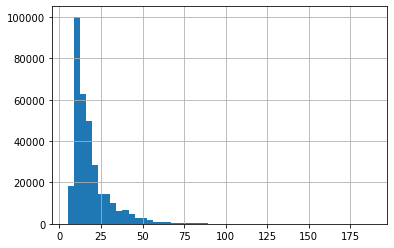

In [14]:
# Computing average encoded length
lengths = pd.Series(list(map(len, list_num_tokens)))
print(lengths.mean())
lengths.hist(bins=50)

In [15]:
# testing truncate length:
TRUNCATE_LEN = 45
print(f'% of names with less than {TRUNCATE_LEN} length is {sum(lengths <= TRUNCATE_LEN) / len(lengths)}')

% of names with less than 45 length is 0.9630844229138321


In [16]:
# padding & truncating sequences
PAD = 'post'
TRUNCATE = 'post'
pad_names = tf.keras.preprocessing.sequence.pad_sequences(list_num_tokens, maxlen=TRUNCATE_LEN, 
                                                          padding=PAD, truncating=TRUNCATE)
print(pad_names.shape)

(327802, 45)


# Constructing the dataset:

Train dataset has the following structure:

Inputs:
- Album cover picture as an input to encoder
- Shifted album quote sequence (artist name + album name) as self-attention input for decoder

Outputs:
- Target sequence

In [17]:
list_ds = tf.data.Dataset.from_tensor_slices((tf.constant(train_albums_data.directory.tolist()),
                                              tf.constant(pad_names)))

In [18]:
labeled_ds = list_ds.map(parse_image)

In [23]:
IMG_HW = 224

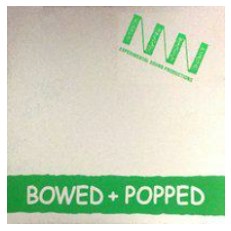

Decoder input: ['<BOS>', '▁Michael', '▁V', 'or', 'f', 'el', 'd', ',', '▁Hans', '▁Tam', 'm', 'en,', '▁Stefan', '▁Fr', 'ol', 'ey', 'ks', '▁<SEP>', '▁Bow', 'ed', '▁And', '▁Pop', 'p', 'ed', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Decoder output: ['▁Michael', '▁V', 'or', 'f', 'el', 'd', ',', '▁Hans', '▁Tam', 'm', 'en,', '▁Stefan', '▁Fr', 'ol', 'ey', 'ks', '▁<SEP>', '▁Bow', 'ed', '▁And', '▁Pop', 'p', 'ed', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


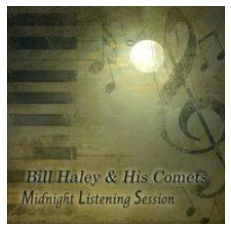

Decoder input: ['<BOS>', '▁Bill', '▁Haley', '▁&', '▁His', '▁Com', 'ets', '▁<SEP>', '▁Midnight', '▁Listening', '▁Session', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Decoder output: ['▁Bill', '▁Haley', '▁&', '▁His', '▁Com', 'ets', '▁<SEP>', '▁Midnight', '▁Listening', '▁Session', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


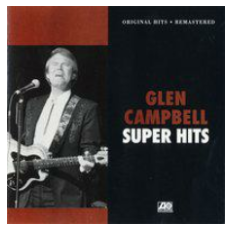

Decoder input: ['<BOS>', '▁Gl', 'en', '▁Campb', 'ell', '▁<SEP>', '▁Super', '▁Hits', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Decoder output: ['▁Gl', 'en', '▁Campb', 'ell', '▁<SEP>', '▁Super', '▁Hits', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


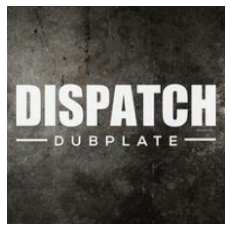

Decoder input: ['<BOS>', '▁Sur', 'v', 'ival', ',', '▁Sc', 'ri', 'pt', '▁<SEP>', '▁Dis', 'p', 'at', 'ch', '▁Dub', 'pl', 'ate', '▁01', '6', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Decoder output: ['▁Sur', 'v', 'ival', ',', '▁Sc', 'ri', 'pt', '▁<SEP>', '▁Dis', 'p', 'at', 'ch', '▁Dub', 'pl', 'ate', '▁01', '6', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


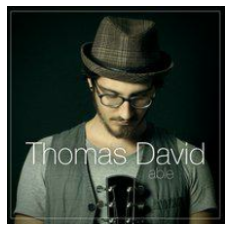

Decoder input: ['<BOS>', '▁Thomas', '▁David', '▁<SEP>', '▁A', 'ble', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Decoder output: ['▁Thomas', '▁David', '▁<SEP>', '▁A', 'ble', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


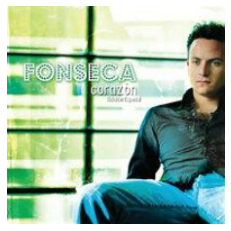

Decoder input: ['<BOS>', '▁F', 'ons', 'ec', 'a', '▁<SEP>', '▁Cor', 'az', 'ón', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Decoder output: ['▁F', 'ons', 'ec', 'a', '▁<SEP>', '▁Cor', 'az', 'ón', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


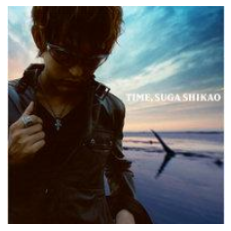

Decoder input: ['<BOS>', '▁Sh', 'ika', 'o', '▁Su', 'ga', '▁<SEP>', '▁Time', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Decoder output: ['▁Sh', 'ika', 'o', '▁Su', 'ga', '▁<SEP>', '▁Time', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


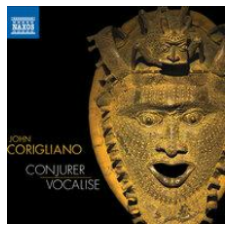

Decoder input: ['<BOS>', '▁Ev', 'el', 'yn', '▁Glenn', 'ie,', '▁H', 'ila', '▁Pl', 'it', 'mann,', '▁Alb', 'any', '▁Symphony', '▁Orchestra,', '▁Mark', '▁Ba', 'ech', 'le,', '▁David', '▁Alan', '▁Miller', '▁<SEP>', '▁Cor', 'ig', 'l', 'iano', ':', '▁Con', 'j', 'ur', 'er', '▁&', '▁Vocal', 'ise', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Decoder output: ['▁Ev', 'el', 'yn', '▁Glenn', 'ie,', '▁H', 'ila', '▁Pl', 'it', 'mann,', '▁Alb', 'any', '▁Symphony', '▁Orchestra,', '▁Mark', '▁Ba', 'ech', 'le,', '▁David', '▁Alan', '▁Miller', '▁<SEP>', '▁Cor', 'ig', 'l', 'iano', ':', '▁Con', 'j', 'ur', 'er', '▁&', '▁Vocal', 'ise', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


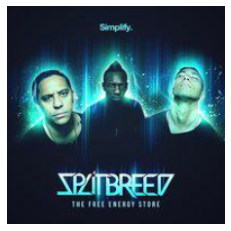

Decoder input: ['<BOS>', '▁Split', 'bre', 'ed', '▁<SEP>', '▁The', '▁Free', '▁Ener', 'gy', '▁St', 'ore', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Decoder output: ['▁Split', 'bre', 'ed', '▁<SEP>', '▁The', '▁Free', '▁Ener', 'gy', '▁St', 'ore', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


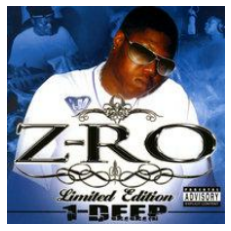

Decoder input: ['<BOS>', '▁Z', '-R', 'O', '▁<SEP>', '▁1', '-D', 'e', 'ep', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Decoder output: ['▁Z', '-R', 'O', '▁<SEP>', '▁1', '-D', 'e', 'ep', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [19]:
for f in labeled_ds.take(10):
    show(f[0][0])
    plt.show()
    print(f'Decoder input: {[yamus_bpe.id_to_subword(wid) for wid in f[0][1]]}')
    print(f'Decoder output: {[yamus_bpe.id_to_subword(wid) for wid in f[1]]}')

# Create Transformer based architecture:

# Image features extractor:

As an encoder ImageNet pretrained MobileNetV2 is used. Encoder maps raw image into the sequence of 49 tokens (each token is encoded with 128 dimensional vector). Last layer adds positional encoding for processing in the transformer decoder.

In [20]:
class ImgFeatures(tf.keras.Model):
    
    def __init__(self, input_shape, enc_dim, alpha=0.5):
        super(ImgFeatures, self).__init__()
        self.alpha = alpha
        self.in_shape = input_shape
        self.enc_dim = enc_dim
        self.pretrained_extractor = tf.keras.applications.MobileNetV2(input_shape=self.in_shape, alpha=self.alpha, 
                                              include_top=False, weights='imagenet',
                                              input_tensor=None, pooling=None)
        self.pretrained_extractor.trainable = False
        
        self.net = tf.keras.models.Sequential([
            self.pretrained_extractor,
            tf.keras.layers.Conv2D(self.enc_dim, kernel_size=(1, 1), strides=(1,1), padding="VALID", activation='relu', name='encoder_pre_transform1'),
            tf.keras.layers.Reshape((7*7, self.enc_dim), input_shape=(7, 7, self.enc_dim)),
            PositionEmbedding(7*7, self.enc_dim, pos_embed_type='trainable')           
        ])
        
    
    def call(self, x):
        return self.net(x)

In [24]:
ImgFeatures([IMG_HW, IMG_HW, 3], 128).net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.50_224 (Model) (None, 7, 7, 1280)        706224    
_________________________________________________________________
encoder_pre_transform1 (Conv (None, 7, 7, 128)         163968    
_________________________________________________________________
reshape_1 (Reshape)          (None, 49, 128)           0         
_________________________________________________________________
position_embedding_1 (Positi (None, 49, 128)           6272      
Total params: 876,464
Trainable params: 170,240
Non-trainable params: 706,224
_________________________________________________________________


# Combine conv net with transformer decoder:

In [25]:
def album_name_net(image_input_shape, decoder_input_shape, model_dim, dec_num_layers,
                   dec_num_heads, vocab_shape, embedding_dim, dropout=0.1, training=True):
    # Processing images in convolutional encoder:
    image_input = tf.keras.layers.Input(image_input_shape)
    encoded_image = ImgFeatures(image_input_shape, model_dim)(image_input)
    # Set up Transformer Decoder
    # Input for teacher-inforcement:
    decoder_input = tf.keras.layers.Input(decoder_input_shape)
    # creating padding and look ahead masks:
    look_ahead_mask = create_look_ahead_mask(tf.shape(decoder_input)[1]) 
    dec_tar_padding_mask = create_padding_mask_equal(decoder_input, value=0)
    combined_mask = tf.maximum(dec_tar_padding_mask, look_ahead_mask)
    # token and position embeddings:
    decoder_emb = TokenAndPositionEmbedding(decoder_input_shape[0], vocab_shape, embedding_dim,
                                            pos_embed_type='trainable', scale_emb=False)(decoder_input)
    # Bulding Transformer decoder
    transformer_decoder, _ = TransformerDecoder(dec_num_layers, model_dim, dec_num_heads, 
                                                model_dim*4, dropout_rate=dropout)(decoder_emb, encoded_image,
                                                                                   training=training,
                                                                                   look_ahead_mask=combined_mask,
                                                                                   padding_mask=None)
    # Performing Softmax:
    decoder_out = tf.keras.layers.TimeDistributed(
                        tf.keras.layers.Dense(vocab_shape, activation='softmax')
                     )(transformer_decoder)
    # Building the model:
    model = tf.keras.Model(inputs=(image_input, decoder_input), outputs=decoder_out)
    return model

In [26]:
album_name_model = album_name_net(image_input_shape=[IMG_HW, IMG_HW, 3], decoder_input_shape=[TRUNCATE_LEN-1], 
                                  model_dim=128, dec_num_layers=3,
                                  dec_num_heads=4, vocab_shape=VOCAB_SHAPE, embedding_dim=128)

In [27]:
album_name_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 44)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(2,)]               0           input_5[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [()]                 0           tf_op_layer_Shape[0][0]          
__________________________________________________________________________________________________
tf_op_layer_packed (TensorFlowO [(2,)]               0           tf_op_layer_strided_slice[0][0]  
                                                                 tf_op_layer_strided_slice[0][

# Create masked loss/accuracy to account for padding:

Maked loss & accuracy are using mask to skip padding tokens when calculating metrics.

In [28]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction='none')

In [29]:
def masked_accuracy(real, pred):
    accuracies = tf.equal(real,  tf.cast(tf.argmax(pred, axis=2), real.dtype))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [30]:
def masked_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

# Set up callbacks and prepare the data:

In [31]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="transformer_training/cp.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)
album_name_model.compile(optimizer='adam',
                         loss=masked_loss,
                         metrics=[masked_accuracy])

In [32]:
# Split dataset into batches:
BATCH_SIZE = 256
all_ds = labeled_ds.shuffle(512).batch(BATCH_SIZE)
val_dataset = labeled_ds.take(28000).shuffle(1024).batch(BATCH_SIZE)
train_dataset = labeled_ds.skip(28000).shuffle(1024).batch(BATCH_SIZE)

In [33]:
# Reload model if needed:
album_name_model.load_weights('transformer_training/cp.ckpt')

# Training the model 

In [132]:
with tf.device(device):
    album_name_model.fit(train_dataset, epochs=10, validation_data=val_dataset, 
                         verbose=1, callbacks=[cp_callback])

Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 5.0623 - masked_accuracy: 0.2132
Epoch 00001: saving model to transformer_training/cp.ckpt
1172/1172 [==============================] - 1103s 941ms/step - loss: 5.0623 - masked_accuracy: 0.2132 - val_loss: 4.2452 - val_masked_accuracy: 0.2798
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 4.0309 - masked_accuracy: 0.3033
Epoch 00002: saving model to transformer_training/cp.ckpt
1172/1172 [==============================] - 1103s 941ms/step - loss: 4.0309 - masked_accuracy: 0.3033 - val_loss: 3.9307 - val_masked_accuracy: 0.3178
Epoch 3/10
1172/1172 [==============================] - ETA: 0s - loss: 3.7977 - masked_accuracy: 0.3311
Epoch 00003: saving model to transformer_training/cp.ckpt
1172/1172 [==============================] - 1104s 942ms/step - loss: 3.7977 - masked_accuracy: 0.3311 - val_loss: 3.8002 - val_masked_accuracy: 0.3362
Epoch 4/10
1172/1172 [==============================] -

In [34]:
with tf.device(device):
    album_name_model.evaluate(val_dataset)

110/110 [==============================] - 83s 752ms/step - loss: 3.5665 - masked_accuracy: 0.3697


# Sample from transformer:

In [35]:
# Supress tensorflow input shape warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

def name_music_album(album_pic, transformer_model, bpe_tokenizer, truncate_len, 
                     bos='<BOS>', eos='<EOS>'):
    
    input_eval = [bpe_tokenizer.subword_to_id(bos)]
    test_image = tf.expand_dims(init_test_image, 0)
    generated_text = []

    max_gen_len = truncate_len-1
    end_token = bpe_tokenizer.subword_to_id(eos)
    step = 0
    predicted_id = input_eval[0]
    while step <= max_gen_len and predicted_id != end_token:
        tmp_eval_input = input_eval[-truncate_len+1:]
        decoder_input = tf.cast(tf.expand_dims(tmp_eval_input, 0), tf.float32)
        predictions = transformer_model((test_image, decoder_input))
        predictions = predictions[: ,-1:, :]
        predicted_id = tf.argmax(predictions, axis=-1)[0][0]

        input_eval.append(predicted_id.numpy())
        generated_text.append(predicted_id.numpy())

        step += 1

    generated_text = [int(token) for token in generated_text if token != end_token ]
    generated_text = bpe_tokenizer.decode(generated_text)
    
    return generated_text

# Show results for test albums:

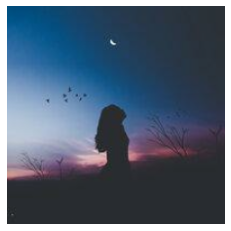

Artist: Musica Relajante Para Dormir
Album: 50 Beautiful Sounds for the World


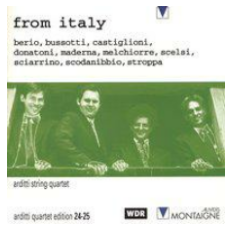

Artist: The Andrew Sisters
Album: The Andrew Sisters: The Andrews Sisters


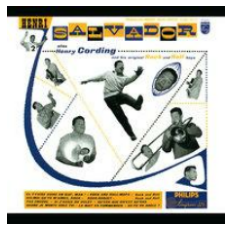

Artist: The Academy of Ancient Music, Christopher Hogwood
Album: Mozart: Piano Concertos Nos. 1 & 29


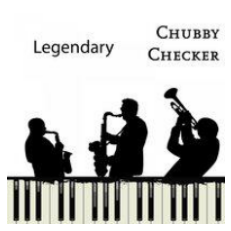

Artist: The Shadows
Album: Legendary


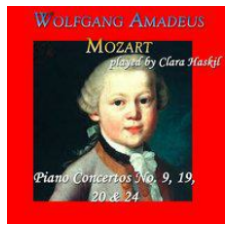

Artist: Paul Badura-Skoda
Album: The Complete Columbia Recordings 1956-1962


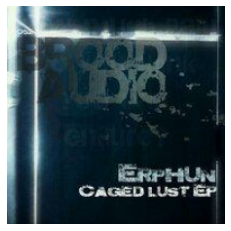

Artist: The Up
Album: The Untold


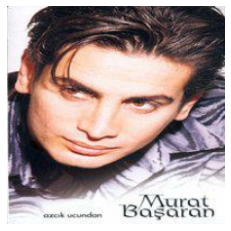

Artist: Игорь Карадская
Album: Васочи


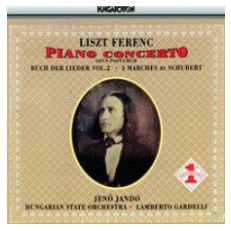

Artist: The Academy Allstars
Album: The Best of Country Music


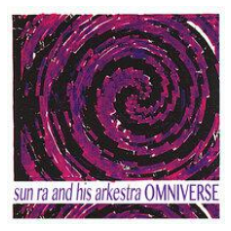

Artist: The Country Dance Kings
Album: The Country Dance Part 2


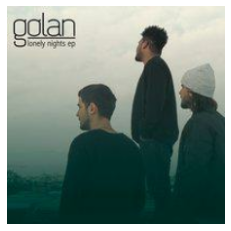

Artist: The Search
Album: The World of the Sun


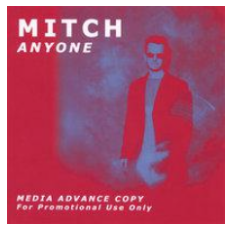

Artist: The Country Dance Kings
Album: The Best of the Country Music


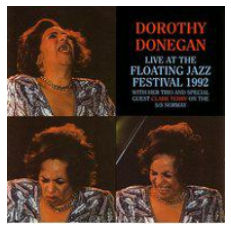

Artist: Orchestre Paul Kuentz, Paul Kuentz, Paul Kuentz, Barbara Schlick, Monique Frasca-Colombier, Paul Kuentz, Barbara Schlick
Album: Bach: Brandenburg Concertos


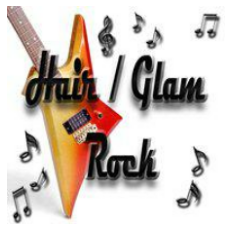

Artist: The Jacka, The Post, The Jacka
Album: The Foolish


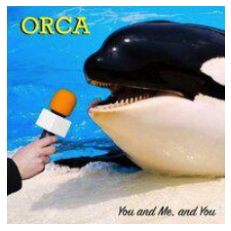

Artist: The Post Of The Universal
Album: The World


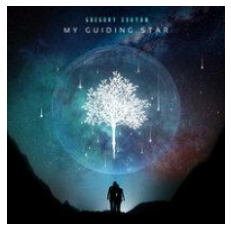

Artist: Aaron
Album: The Unlimited


In [41]:
random_albums = np.random.choice(test_albums_data.shape[0], 15, replace=False)

for r_alb in random_albums:
    
    test_album = test_albums_data.directory.to_list()[int(r_alb)]

    img_dec, _ = parse_image(test_album, ['<BOS>'] * TRUNCATE_LEN)
    init_test_image, _ = img_dec

    generated_text = name_music_album(album_pic=init_test_image,
                                      transformer_model=album_name_model,
                                      bpe_tokenizer=yamus_bpe,
                                      truncate_len=TRUNCATE_LEN)

    generated_text = ''.join(generated_text)
    artist, album = split_artist_album(generated_text)
                 
    show(init_test_image)
    plt.show()
    print(f'Artist: {artist}\nAlbum: {album}')

# Generate music album quotes for arbitary images:

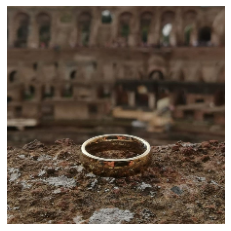

Artist: The New Age Meditators
Album: The Ultimate Collection


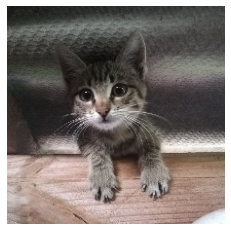

Artist: The Ventures
Album: The Best of the Best Of The Ventures


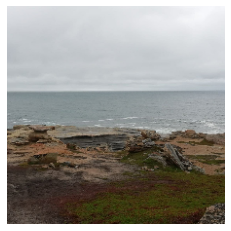

Artist: Musica reiki
Album: Meditation: Relaxing Music for Meditation


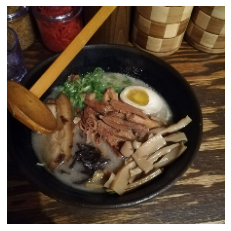

Artist: The Vidjoriths
Album: The Best of the Best of


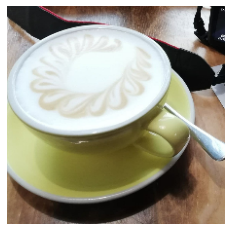

Artist: The Chillout Players
Album: Chill Out Lounge


In [55]:
user_albums = os.listdir('user_imgs')

for u_alb in user_albums:
    
    test_album = f'user_imgs/{u_alb}'

    img_dec, _ = parse_image(test_album, ['<BOS>'] * TRUNCATE_LEN)
    init_test_image, _ = img_dec

    generated_text = name_music_album(album_pic=init_test_image,
                                      transformer_model=album_name_model,
                                      bpe_tokenizer=yamus_bpe,
                                      truncate_len=TRUNCATE_LEN)

    generated_text = ''.join(generated_text)
    artist, album = split_artist_album(generated_text)
                 
    show(init_test_image)
    plt.show()
    print(f'Artist: {artist}\nAlbum: {album}')